In [1]:
import importlib
import matplotlib.pyplot as plt
import benchmark_module
importlib.reload(benchmark_module)

<module 'benchmark_module' from '/home/wolfie/search-forests/benchmark_module.cpython-310-x86_64-linux-gnu.so'>

In [2]:
from benchmark_module import \
    benchmark, \
    generate_zipf_queries, \
    generate_noisy_frequencies, \
    generate_noisy_accesses, \
    RandomEngine

In [20]:
NUM_KEYS = 100_000
NUM_QUERIES = 100_000
ZIPF_ALPHA = 1.0
PRED_DELTA = 1
GEN = RandomEngine(seed=42)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_res(li, structures, query_stats, insert_stats, x_label, y_label, show_insert=False):
    w = 0.12
    bar_spacing = 0.02
    group_spacing = 0.16

    group_width = len(structures) * (w + bar_spacing) + group_spacing
    colors = sns.color_palette("tab20", len(structures))

    if show_insert:
        fig, axes = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)
        ax1, ax2 = axes
    else:
        fig, ax2 = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

    x = range(len(li))

    if show_insert:
        all_insert_values = [insert_stats[a][s] for a in li for s in structures]
        min_insert = min(all_insert_values)
        max_insert = 5 * min_insert

        for i, s in enumerate(structures):
            y = [insert_stats[a][s] for a in li]
            bar_positions = [xi * group_width + i * (w + bar_spacing) for xi in x]
            ax1.bar(bar_positions, [min(v, max_insert) for v in y], width=w, label=s, color=colors[i])
            for j, val in enumerate(y):
                if val > max_insert:
                    ax1.text(bar_positions[j], max_insert + 0.02 * max_insert, f"{val:.2f}",
                             ha='center', va='bottom', fontsize=8, rotation=45)

        ax1.set_ylim(0, max_insert * 1.15)
        ax1.set_xticks([xi * group_width + (len(structures) - 1) * (w + bar_spacing) / 2 for xi in x])
        ax1.set_xticklabels([f"{v:,}" for v in li])
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(f"{y_label} (insert)")
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

    all_query_values = [query_stats[a][s] for a in li for s in structures]
    min_query = min(all_query_values)
    max_query = 5 * min_query

    for i, s in enumerate(structures):
        y2 = [query_stats[a][s] for a in li]
        bar_positions = [xi * group_width + i * (w + bar_spacing) for xi in x]
        ax2.bar(bar_positions, [min(v, max_query) for v in y2], width=w, label=s, color=colors[i])
        for j, val in enumerate(y2):
            if val > max_query:
                ax2.text(bar_positions[j], max_query + 0.02 * max_query, f"{val:.2f}",
                         ha='center', va='bottom', fontsize=8, rotation=45)

    ax2.set_ylim(0, max_query * 1.15)
    ax2.set_xticks([xi * group_width + (len(structures) - 1) * (w + bar_spacing) / 2 for xi in x])
    ax2.set_xticklabels([f"{v:,}" for v in li])
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(f"{y_label} (query)")
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    fig.legend(structures, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
    plt.show()

In [5]:
def run_key_experiments(num_keys_options, num_queries, alpha, delta, gen):
    query_stats = {}
    insert_stats = {}
        
    for num_keys in num_keys_options:
        queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
        frequencies = generate_noisy_frequencies(queries, num_keys, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, delta, gen)
        out = benchmark(queries, frequencies, accesses, gen)

        query_stats[num_keys] = out["queries"]["comparisons"]
        insert_stats[num_keys] = out["inserts"]["comparisons"]
        
    structures = list(query_stats[num_keys_options[0]].keys())
    x_label = "Number of keys"
    y_label = f"Average number of comparisons"
    
    plot_res(num_keys_options, structures, query_stats, insert_stats, x_label, y_label, True)


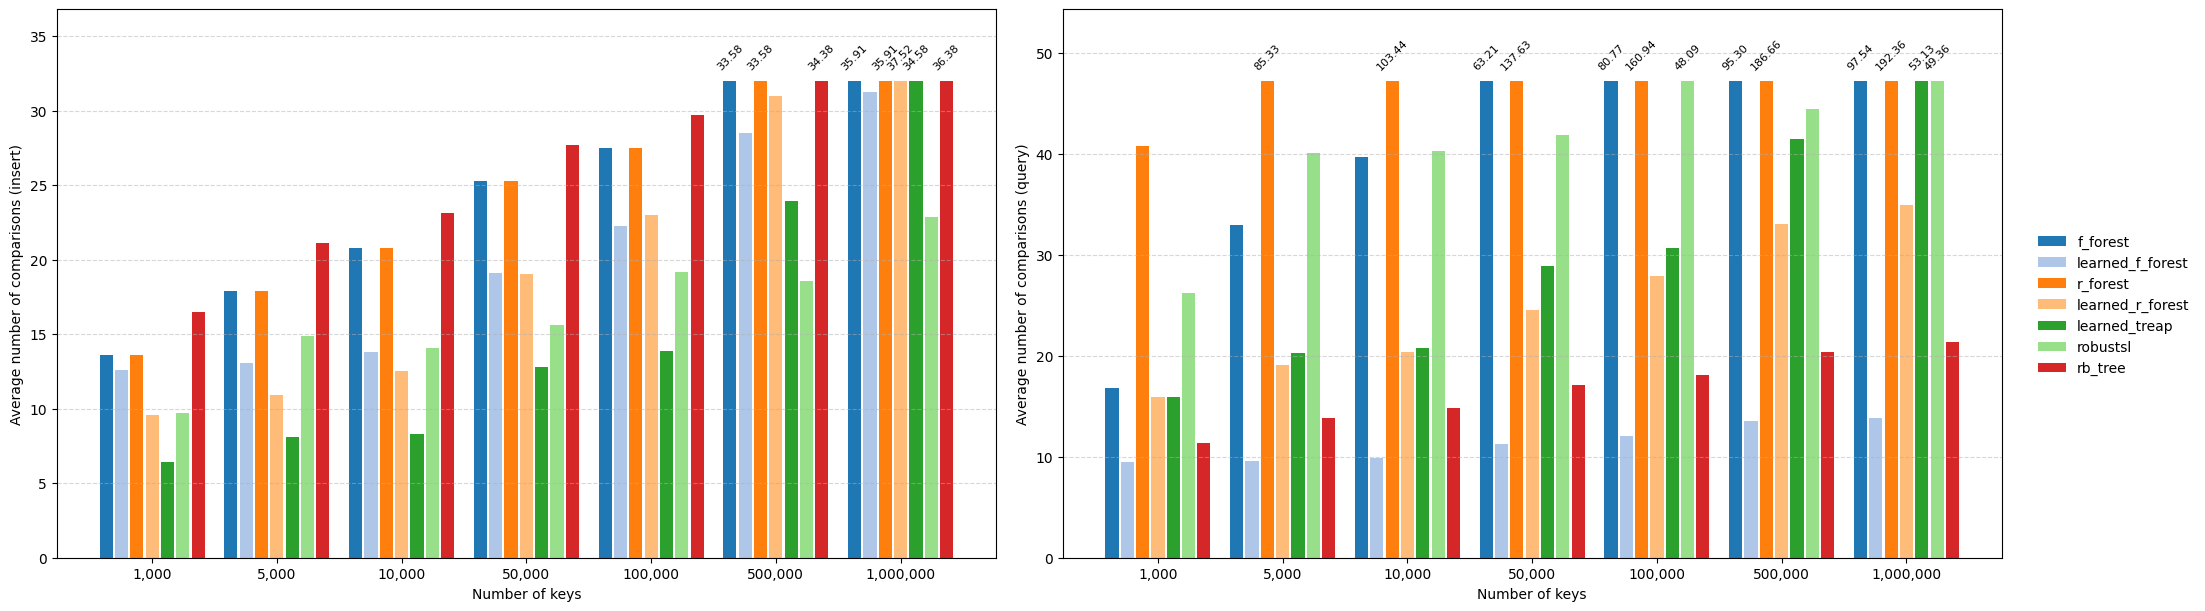

In [6]:
num_keys_options = [1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000]
run_key_experiments(num_keys_options, NUM_QUERIES, ZIPF_ALPHA, PRED_DELTA, GEN)

In [7]:
def run_alpha_experiments(num_keys, num_queries, alpha_options, delta, gen):
    query_stats = {}
    insert_stats = {}
        
    for alpha in alpha_options:
        queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
        frequencies = generate_noisy_frequencies(queries, num_keys, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, delta, gen)
        out = benchmark(queries, frequencies, accesses, gen)

        query_stats[alpha] = out["queries"]["comparisons"]
        insert_stats[alpha] = out["inserts"]["comparisons"]
        
    structures = list(query_stats[alpha_options[0]].keys())
    x_label = "Zipf parameter alpha"
    y_label = f"Average number of comparisons"
    
    plot_res(alpha_options, structures, query_stats, insert_stats, x_label, y_label)

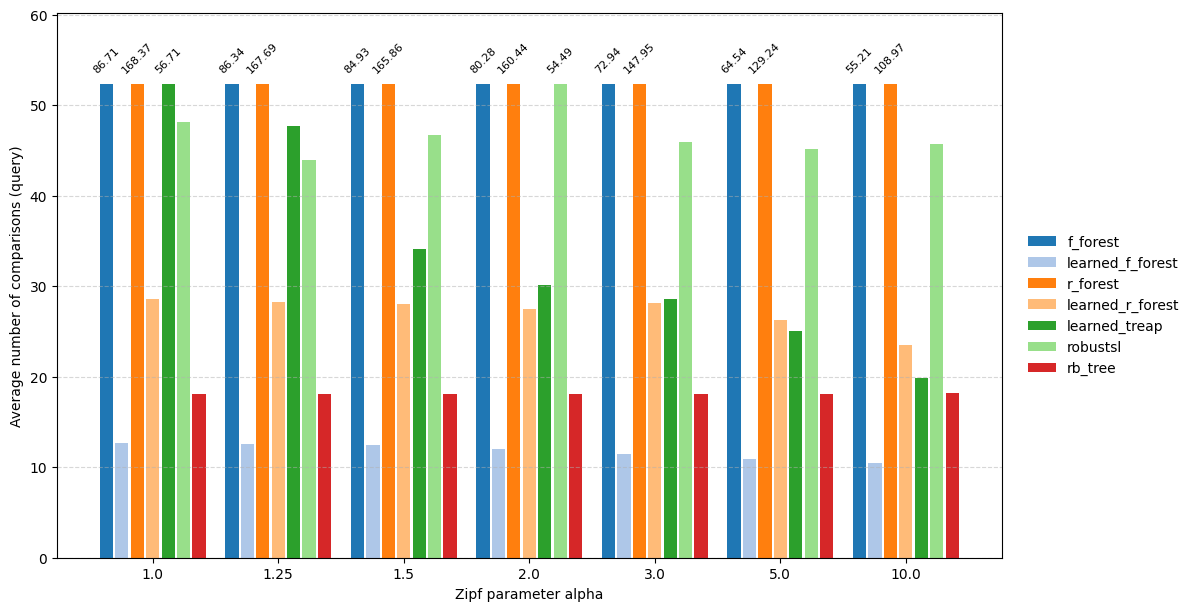

In [8]:
alpha_options = [1., 1.25, 1.5, 2., 3., 5., 10.]
run_alpha_experiments(NUM_KEYS, NUM_QUERIES, alpha_options, PRED_DELTA, GEN)

In [18]:
def run_delta_experiments(num_keys, num_queries, alpha, delta_options, gen):
    query_stats = {}
    insert_stats = {}
        
    queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
    for delta in delta_options:
        frequencies = generate_noisy_frequencies(queries, num_keys, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, delta, gen)
        out = benchmark(queries, frequencies, accesses, gen)

        query_stats[delta] = out["queries"]["comparisons"]
        insert_stats[delta] = out["inserts"]["comparisons"]
        print("compactions: ", out["queries"]["compactions"], flush=True)
        print(frequencies[0:10], flush=True)
        
    structures = list(query_stats[delta_options[0]].keys())
    x_label = "Error parameter delta"
    y_label = f"Average number of comparisons"
    
    plot_res(delta_options, structures, query_stats, insert_stats, x_label, y_label)

compactions:  {'f_forest': 48602, 'learned_f_forest': 0, 'r_forest': 360479, 'learned_r_forest': 1}
[2, 0, 1, 1, 2, 0, 3, 0, 1, 0]
compactions:  {'f_forest': 48602, 'learned_f_forest': 0, 'r_forest': 360479, 'learned_r_forest': 1}
[4, 0, 0, 1, 2, 0, 3, 0, 0, 0]
compactions:  {'f_forest': 48602, 'learned_f_forest': 0, 'r_forest': 360479, 'learned_r_forest': 1}
[2, 0, 0, 0, 6, 0, 1, 0, 0, 0]
compactions:  {'f_forest': 48602, 'learned_f_forest': 0, 'r_forest': 360479, 'learned_r_forest': 1}
[0, 0, 0, 7, 12, 0, 3, 0, 0, 0]
compactions:  {'f_forest': 48602, 'learned_f_forest': 0, 'r_forest': 360479, 'learned_r_forest': 1}
[0, 0, 16, 0, 36, 0, 48, 0, 24, 0]
compactions:  {'f_forest': 48602, 'learned_f_forest': 0, 'r_forest': 360479, 'learned_r_forest': 1}
[96, 0, 0, 0, 0, 0, 135, 0, 30, 0]
compactions:  {'f_forest': 48602, 'learned_f_forest': 0, 'r_forest': 360479, 'learned_r_forest': 1}
[0, 0, 0, 1172088124, 0, 0, 1139354610, 0, 904585705, 0]


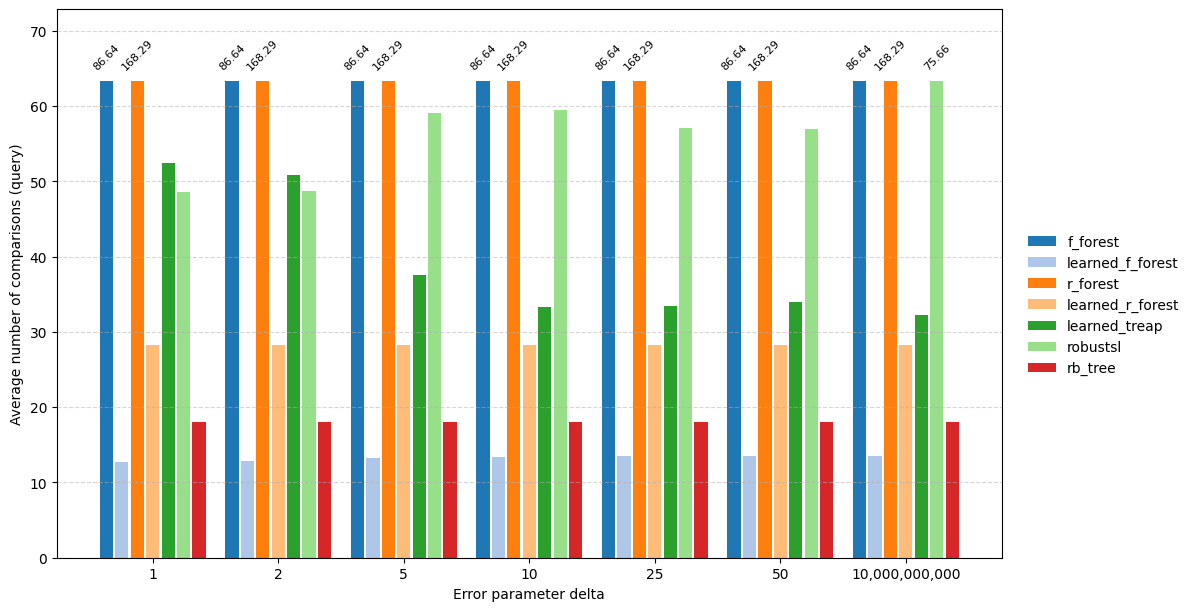

In [22]:
delta_options = [1, 2, 5, 10, 25, 50, 10000000000]
run_delta_experiments(NUM_KEYS, NUM_QUERIES, ZIPF_ALPHA, delta_options, GEN)